## 2차 목표

1. Github private repo 만들고 branch 생성
2. `model.train()`, `model.eval()` 정리
  - 써야하는 이유
  - 써야하는 위치
3. epcoh별 loss, acc 찍히게 만들어보기
  - accuracy 계산 참고 -> https://deep-learning-study.tistory.com/368
4. valid acc 수렴할 때까지 학습 충분히 시키기
5. submission 제출해서 점수 올리기 

## PyTorch on MNIST by LeNet

1. import libraries
2. check cuda
3. load data
4. split train, val and test
5. define
  - LeNet (layer, forward, ...)
  - loss function, optimizer
  - Train, eval and test


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/kaggle/MNIST'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

/content/drive/MyDrive/kaggle/MNIST/train.csv
/content/drive/MyDrive/kaggle/MNIST/test.csv
/content/drive/MyDrive/kaggle/MNIST/sample_submission.csv
/content/drive/MyDrive/kaggle/MNIST/LeNet.ipynb
/content/drive/MyDrive/kaggle/MNIST/LeNet_1
/content/drive/MyDrive/kaggle/MNIST/submission.csv
/content/drive/MyDrive/kaggle/MNIST/LeNet_1의 사본


In [3]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.autograd import Variable
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [4]:
torch.manual_seed(777)

In [5]:
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda' if USE_CUDA else "cpu")
print(device)

cpu


In [6]:
# Load data
train = pd.read_csv(r"/content/drive/MyDrive/kaggle/MNIST/train.csv", dtype=np.float32)
test = pd.read_csv(r"/content/drive/MyDrive/kaggle/MNIST/test.csv", dtype=np.float32)

In [7]:
print(len(train))
print(len(test))

42000
28000


In [8]:
# split data into X(pixels) and Y(numbers from 0 to 9)
X = train.loc[:, train.columns != 'label'].values / 255
Y = train.label.values

In [9]:
print(type(X))
print(type(Y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [10]:
# train test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [11]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(33600, 784)
(8400, 784)
(33600,)
(8400,)


- Create feature and targets tensor for train set. As you remember we need **variable** to accumulate gradients. Therefore first we *create tensor*, then we will *create variable*.

In [12]:
# create X and Y tensor
X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train).type(torch.LongTensor)  # data type is long

X_val = torch.from_numpy(X_val)
Y_val = torch.from_numpy(Y_val).type(torch.LongTensor) # data type is long

In [13]:
print(type(X_train))
print(type(X_val))
print(type(Y_train))
print(type(Y_val))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


error: `typeerror: expected np.ndarray (got tensor)`

https://forum.jovian.ai/forum/t/typeerror-expected-np-ndarray-got-tensor/6100


In [14]:
# batch size, epoch and iteration
batch_size =100
epochs = 30

In [15]:
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train, Y_train)
validation = torch.utils.data.TensorDataset(X_val, Y_val)

In [16]:
# Data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(validation, batch_size = batch_size, shuffle = True)
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).

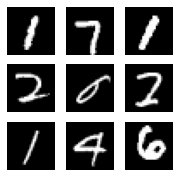

In [17]:
# sample 9 mnist digits from train dataset

index = np.random.randint(0, X_train.shape[0], size=9)
images = X_train[index]
labels = Y_train[index]

plt.figure(figsize=(3,3))

for i in range(len(index)):
  plt.subplot(3,3,i+1)
  image = images[i].reshape(28,28)
  plt.imshow(image, cmap='gray')
  plt.axis('off')

plt.show()

## Model

이거 LeNet을 짠거!

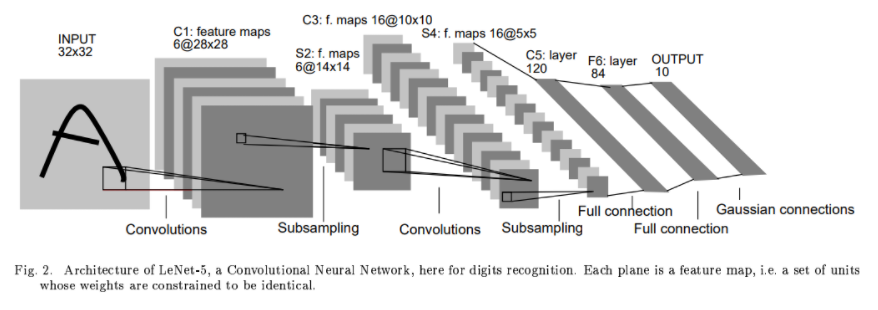

In [18]:
class LeNet(nn.Module):
  def __init__(self, num_classes):
    super(LeNet, self).__init__()

    # C1 (1,6,5)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
    

    # C2 (6, 16, 5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
    
    # C3 (16, 120, 5)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)
    
    # fc
    self.fc1 = nn.Linear(120, 84)
    self.fc2 = nn.Linear(84, 10)

    # Connect layers, define activation function
  def forward(self, x):
     # Max pooling over a (2, 2) window
     x = F.relu(self.conv1(x))
     x = F.avg_pool2d(x, 2)

     x = F.relu(self.conv2(x))
     x = F.dropout(x, p=0.5, training=self.training)
     x = F.avg_pool2d(x, 2)

     x = F.relu(self.conv3(x))
     x = F.dropout(x, p=0.5, training=self.training)
     x = x.view(-1, 120)

     x = F.relu(self.fc1(x))
     x = self.fc2(x)

     return F.softmax(x, dim=1)

In [19]:
epochs = 15
num_classes = 10

In [20]:
model = LeNet(num_classes).to(device)
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [21]:
input = torch.randn(1, 32, 32)
model(input)

tensor([[0.0895, 0.1000, 0.0943, 0.1118, 0.0925, 0.1015, 0.0971, 0.1045, 0.1057,
         0.1032],
        [0.0941, 0.1023, 0.0973, 0.1091, 0.0981, 0.0970, 0.0969, 0.0969, 0.1098,
         0.0985],
        [0.0917, 0.0991, 0.0978, 0.1128, 0.0934, 0.1018, 0.0986, 0.1038, 0.1023,
         0.0987],
        [0.0919, 0.1000, 0.0964, 0.1165, 0.0941, 0.1007, 0.0949, 0.1062, 0.1006,
         0.0987]], grad_fn=<SoftmaxBackward0>)

In [22]:
from torchsummary import summary
summary(model, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             156
            Conv2d-2           [-1, 16, 12, 12]           2,416
            Conv2d-3            [-1, 120, 2, 2]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [23]:
# Define cost function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

## tensor size 확인

In [24]:
for batch_idx, (image, label) in enumerate(train_loader):
  break

In [25]:
image

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [26]:
image.shape

torch.Size([100, 784])

In [27]:
image.size(0)

100

In [28]:
label

tensor([4, 4, 7, 2, 0, 1, 1, 4, 2, 6, 5, 4, 1, 7, 2, 9, 9, 8, 4, 0, 1, 1, 2, 2,
        9, 8, 6, 8, 0, 1, 7, 1, 2, 5, 2, 4, 7, 8, 2, 7, 0, 4, 8, 0, 4, 8, 8, 0,
        7, 7, 8, 8, 0, 5, 9, 3, 1, 3, 2, 2, 6, 9, 3, 3, 8, 1, 2, 8, 0, 7, 7, 8,
        0, 0, 4, 4, 9, 8, 2, 8, 8, 8, 4, 0, 5, 7, 7, 0, 2, 9, 9, 4, 2, 5, 9, 8,
        0, 1, 0, 2])

In [29]:
label.size

<function Tensor.size>

In [30]:
for epoch in range(epochs):
    for i, (X, Y) in enumerate(train_loader):
        X, Y = X.to(device), Y.to(device)
        train = Variable(X.view(100,1,28,28))
        labels = Variable(Y)

In [31]:
for batch_idx, (image, label) in enumerate(train_loader):
  image, label = image.to(device), label.to(device)
  image = Variable(image.view(100,1,28,28))
  label = Variable(label)
  break

In [32]:
image.shape

torch.Size([100, 1, 28, 28])

In [33]:
label.size

<function Tensor.size>

In [34]:
steps = 0
print_every = 50
train_losses, test_losses = [], []

- (33600, 784) 인데 batch_size=100으로 해서 input이 [100, 784]가 된 것인가?
- 이것을 3D or 4D 로 batched 해주는 방법 -> view

## Train & Evaluate

In [35]:
epochs = 30
train_losses, val_losses = [], []

- train loss와 val loss를 계산하는 방법
- acc 를 계산하는 방법
- validation 단계에서는 역전파를 수행하지 않음 -> 왜?

In [36]:
for epoch in range(epochs):

    correct = 0

    model.train()
    
    for batch_idx, (image, label) in enumerate(train_loader):

      image, label = image.to(device), label.to(device)
      image = Variable(image.view(100,1,28,28))
      label = Variable(label)

      optimizer.zero_grad()
      output = model(image)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()

      # Total correct predictions
      predicted = torch.max(output.data, 1)[1]
      correct += (predicted == label).sum()
 
    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
          "Train Loss: {:.3f}.. ".format(loss.data),
          "Train acc: {:.3f}..".format(float(correct*100) / float(batch_size*len(train_loader))))

Epoch: 1/30..  Train Loss: 2.301..  Train acc: 10.375..
Epoch: 2/30..  Train Loss: 2.302..  Train acc: 14.110..
Epoch: 3/30..  Train Loss: 2.297..  Train acc: 17.982..
Epoch: 4/30..  Train Loss: 1.816..  Train acc: 46.083..
Epoch: 5/30..  Train Loss: 1.776..  Train acc: 68.738..
Epoch: 6/30..  Train Loss: 1.713..  Train acc: 71.812..
Epoch: 7/30..  Train Loss: 1.861..  Train acc: 73.432..
Epoch: 8/30..  Train Loss: 1.656..  Train acc: 78.598..
Epoch: 9/30..  Train Loss: 1.668..  Train acc: 81.280..
Epoch: 10/30..  Train Loss: 1.716..  Train acc: 82.366..
Epoch: 11/30..  Train Loss: 1.625..  Train acc: 83.503..
Epoch: 12/30..  Train Loss: 1.636..  Train acc: 84.062..
Epoch: 13/30..  Train Loss: 1.521..  Train acc: 88.074..
Epoch: 14/30..  Train Loss: 1.539..  Train acc: 91.914..
Epoch: 15/30..  Train Loss: 1.536..  Train acc: 92.554..
Epoch: 16/30..  Train Loss: 1.520..  Train acc: 93.071..
Epoch: 17/30..  Train Loss: 1.520..  Train acc: 93.417..
Epoch: 18/30..  Train Loss: 1.540..  Tra

In [37]:
for epoch in range(epochs):

    correct = 0
    
    model.eval()

    for images, labels in val_loader:

      images, labels = images.to(device), labels.to(device)
      images = Variable(images.view(100,1,28,28))
      labels = Variable(labels)

      outputs = model(images)

      v_loss = criterion(outputs, labels)

      # Total correct predictions
      predicted = torch.max(outputs.data, 1)[1]
      correct += (predicted == labels).sum()

    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
          "Val Loss: {:.3f}.. ".format(v_loss.data),
          "Val acc: {:.3f}..".format(float(correct*100) / float(batch_size*len(val_loader))))

Epoch: 1/30..  Val Loss: 1.475..  Val acc: 97.071..
Epoch: 2/30..  Val Loss: 1.473..  Val acc: 97.071..
Epoch: 3/30..  Val Loss: 1.506..  Val acc: 97.071..
Epoch: 4/30..  Val Loss: 1.491..  Val acc: 97.071..
Epoch: 5/30..  Val Loss: 1.489..  Val acc: 97.071..
Epoch: 6/30..  Val Loss: 1.462..  Val acc: 97.071..
Epoch: 7/30..  Val Loss: 1.478..  Val acc: 97.071..
Epoch: 8/30..  Val Loss: 1.491..  Val acc: 97.071..
Epoch: 9/30..  Val Loss: 1.469..  Val acc: 97.071..
Epoch: 10/30..  Val Loss: 1.482..  Val acc: 97.071..
Epoch: 11/30..  Val Loss: 1.501..  Val acc: 97.071..
Epoch: 12/30..  Val Loss: 1.515..  Val acc: 97.071..
Epoch: 13/30..  Val Loss: 1.472..  Val acc: 97.071..
Epoch: 14/30..  Val Loss: 1.487..  Val acc: 97.071..
Epoch: 15/30..  Val Loss: 1.489..  Val acc: 97.071..
Epoch: 16/30..  Val Loss: 1.482..  Val acc: 97.071..
Epoch: 17/30..  Val Loss: 1.477..  Val acc: 97.071..
Epoch: 18/30..  Val Loss: 1.541..  Val acc: 97.071..
Epoch: 19/30..  Val Loss: 1.502..  Val acc: 97.071..
Ep

## Preparing Test Data for Prediction

In [38]:
final_test_np = test.values / 255
test_tn = torch.from_numpy(final_test_np)

In [39]:
final_test_np

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [40]:
test_tn

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [41]:
print(final_test_np.shape)
print(test_tn.shape)

(28000, 784)
torch.Size([28000, 784])


In [42]:
print(type(final_test_np))
print(type(test_tn))

<class 'numpy.ndarray'>
<class 'torch.Tensor'>


In [43]:
sample_sub = pd.read_csv("/content/drive/MyDrive/kaggle/MNIST/sample_submission.csv")

In [44]:
sample_sub.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [45]:
fake_labels = np.zeros(final_test_np.shape)
fake_labels = torch.from_numpy(fake_labels)

In [46]:
submission_tn_data = torch.utils.data.TensorDataset(test_tn, fake_labels)

submission_loader = DataLoader(submission_tn_data,
                                                batch_size = batch_size, 
                                                shuffle = True)

In [47]:
# Making it submission ready
submission = [['ImageId', 'Label']]

# Turn off gradients for validation
with torch.no_grad():
    model.eval()
    image_id = 1
    
    for images, _ in submission_loader:
        images = Variable(images.view(100,1,28,28))
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        
        for prediction in top_class:
            submission.append([image_id, prediction.item()])
            image_id += 1

In [48]:
# Making it submission ready
submission = [['ImageId', 'Label']]

# Turn off gradients for validation
with torch.no_grad():
    model.eval()
    image_id = 1
    
    for images, _ in submission_loader:
        images = Variable(images.view(100,1,28,28))

        ps = model(images)
        predictions = torch.argmax(ps, 1)
        
        for prediction in predictions:
            submission.append([image_id, prediction.item()])
            image_id += 1

In [49]:
predictions

tensor([9, 0, 6, 2, 0, 3, 1, 3, 8, 6, 2, 4, 1, 1, 4, 9, 3, 5, 6, 2, 1, 6, 9, 3,
        8, 2, 6, 3, 0, 0, 6, 9, 4, 1, 5, 8, 3, 4, 0, 0, 1, 5, 0, 5, 1, 5, 4, 8,
        8, 2, 0, 4, 8, 4, 7, 8, 0, 0, 2, 5, 8, 6, 9, 3, 0, 7, 8, 5, 1, 4, 6, 9,
        4, 1, 7, 7, 4, 6, 8, 3, 1, 4, 9, 2, 2, 0, 1, 0, 5, 1, 6, 8, 5, 1, 5, 7,
        7, 6, 2, 2])

In [50]:
submission_df = pd.DataFrame(submission)
submission_df.columns = submission_df.iloc[0]
submission_df = submission_df.drop(0, axis=0)

In [51]:
submission_df.to_csv("/content/drive/MyDrive/kaggle/MNIST/submission.csv", index=False)

In [54]:
submission_df['Label'].value_counts()

1    3230
7    2928
2    2800
6    2770
0    2770
4    2764
9    2760
3    2749
8    2721
5    2508
Name: Label, dtype: int64

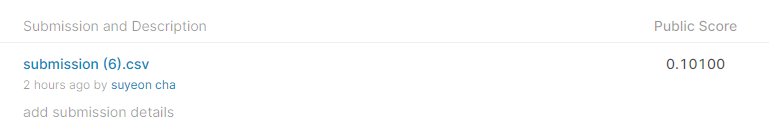

**기존 문제점**

- loss 값이 떨어지고 있으나 여전히 높다(잘 되는지 모르겠음)
- accuracy는 계속 높아짐
    
    → 이거 완전 **overfitting**이 아닌지?…
    
</br>

**시도한 점**

- activation function 변경: `tanh` → `relu`
- model 변경: dropout 넣음
    - 변경 코드 & 결과
        
```python
class LeNet(nn.Module):
  def __init__(self, num_classes):
    super(LeNet, self).__init__()

    # C1 (1,6,5)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
    

    # C2 (6, 16, 5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
    
    # C3 (16, 120, 5)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)
    
    # fc
    self.fc1 = nn.Linear(120, 84)
    self.fc2 = nn.Linear(84, 10)

    # Connect layers, define activation function
  def forward(self, x):
     # Max pooling over a (2, 2) window
     x = F.relu(self.conv1(x))
     x = F.avg_pool2d(x, 2)

     x = F.relu(self.conv2(x))
     x = F.dropout(x, p=0.5, training=self.training)
     x = F.avg_pool2d(x, 2)

     x = F.relu(self.conv3(x))
     x = F.dropout(x, p=0.5, training=self.training)
     x = x.view(-1, 120)

     x = F.relu(self.fc1(x))
     x = self.fc2(x)

     return F.softmax(x, dim=1)
```
        
- epoch 15 → 30
    - `train` : 조금씩 꾸준히 오르고 있음. 하지만 training data로 판단 불가.
    - `val` : val accuracy는 저번부터 계속 같은 수치…


</br>

**시도할 수 있는 점**
- cost function 변경 (SGD → Adam)
  - 원인이 아닌 것 같아서 굳이 하지 않았음